### Importing libraries

In [1]:
import math
import pprint
import datetime
import numpy as np
import pandas as pd
from dateutil import parser
from functools import reduce
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
%matplotlib inline

### Global variables

In [3]:
DATA_DIR = '../data'

STARTING_VAULT_AMOUNT = 2000
PP = pprint.PrettyPrinter(depth=6)

### Reading and basic preprocessing of data

In [4]:
raw_asset_a = pd.read_csv(f'{DATA_DIR}/PERTH-AUD_USD_D.csv')

# The prices/numbers are in ',' seperated values.
# raw_asset_a['Price'] = raw_asset_a['Open'].astype(float)
raw_asset_a['Price'] = raw_asset_a['Bid Average'] #.astype(float)

raw_asset_a = raw_asset_a.loc[:, ['Date', 'Bid Average']]
raw_asset_a.columns = ['Date', 'Price_1']

print('Shape is ({}, {})'.format(*raw_asset_a.shape))
print('Data ranges from {} to {}'.format(raw_asset_a.iloc[0, 0], raw_asset_a.iloc[-1, 0]))
raw_asset_a.tail()

Shape is (8228, 2)
Data ranges from 2020-08-31 to 1991-06-21


,Date,Price_1
8223,1991-06-26,0.7667
8224,1991-06-25,0.7650
8225,1991-06-24,0.7628
8226,1991-06-22,0.7645
8227,1991-06-21,0.7650


In [5]:
raw_asset_b = pd.read_csv(f'{DATA_DIR}/PERTH-GOLD_USD_D.csv')

raw_asset_b['Price'] = raw_asset_b['Bid Average'] #.astype(float)

raw_asset_b = raw_asset_b.loc[:, ['Date', 'Bid Average']]
raw_asset_b.columns = ['Date', 'Price_2']

print('Shape is ({}, {})'.format(*raw_asset_b.shape))
print('Data ranges from {} to {}'.format(raw_asset_b.iloc[0, 0], raw_asset_b.iloc[-1, 0]))
raw_asset_b.tail()

Shape is (9382, 2)
Data ranges from 2020-08-31 to 1991-06-21


,Date,Price_2
9377,1991-06-25,363.02
9378,1991-06-24,365.48
9379,1991-06-23,NaN
9380,1991-06-22,366.10
9381,1991-06-21,367.20


In [6]:
raw_asset_c = pd.read_csv(f'{DATA_DIR}/PERTH-GOLD_USD_D.csv')

raw_asset_c['Price'] = raw_asset_c['Bid Average'] #.astype(float)

raw_asset_c = raw_asset_c.loc[:, ['Date', 'Bid Average']]
raw_asset_c.columns = ['Date', 'Price_3']

print('Shape is ({}, {})'.format(*raw_asset_c.shape))
print('Data ranges from {} to {}'.format(raw_asset_b.iloc[0, 0], raw_asset_b.iloc[-1, 0]))
raw_asset_c.tail()

Shape is (9382, 2)
Data ranges from 2020-08-31 to 1991-06-21


,Date,Price_3
9377,1991-06-25,363.02
9378,1991-06-24,365.48
9379,1991-06-23,NaN
9380,1991-06-22,366.10
9381,1991-06-21,367.20


### Creating  a df for model with 2 assets.

In [9]:
# This will merge both df according to their "Date" column and will
# fill nan in case a date is present in one and absent in other dataframe.
raw_df = raw_asset_a.merge(raw_asset_b, how='outer', left_on='Date', right_on='Date')

raw_df['Date'] = pd.to_datetime(raw_df['Date'])

raw_df = raw_df.loc[:, ['Date', 'Price_1', 'Price_2']]
raw_df.columns = ['Date', 'Price_A', 'Price_B']

print('Shape is ({}, {})'.format(*raw_df.shape))
print('Are null values present: {}'.format(raw_df.isna().values.any()))
print('Data ranges from {} to {}'.format(raw_df.iloc[0, 0], raw_df.iloc[-1, 0]))
raw_df.tail()

Shape is (9382, 3)
Are null values present: True
Data ranges from 2020-08-31 00:00:00 to 1991-06-23 00:00:00


,Date,Price_A,Price_B
9377,1991-07-21,NaN,NaN
9378,1991-07-14,NaN,NaN
9379,1991-07-07,NaN,NaN
9380,1991-06-30,NaN,NaN
9381,1991-06-23,NaN,NaN


In [10]:
# Will replace the nan values with the last valid observation for that column.
raw_df = raw_df.sort_values(by='Date').reset_index(drop=True)
raw_df = raw_df.ffill(axis=0).sort_values(by='Date').reset_index(drop=True)

print('Shape is ({}, {})'.format(*raw_df.shape))
print('Are null values present: {}'.format(raw_df.isna().values.any()))
print('Data ranges from {} to {}'.format(raw_df.iloc[0, 0], raw_df.iloc[-1, 0]))

raw_df.head()

Shape is (9382, 3)
Are null values present: False
Data ranges from 1991-06-21 00:00:00 to 2020-08-31 00:00:00


,Date,Price_A,Price_B
0,1991-06-21,0.7650,367.20
1,1991-06-22,0.7645,366.10
2,1991-06-23,0.7645,366.10
3,1991-06-24,0.7628,365.48
4,1991-06-25,0.7650,363.02


In [27]:
# For selecting years of data.
start_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-30* 365, unit='D') 
end_date = pd.Timestamp('today').floor('D') + pd.Timedelta(30, unit='D')

df = raw_df[
        (raw_df['Date']>=start_date) & (raw_df['Date']<=end_date)
     ].sort_values(by='Date').reset_index(drop=True)

print('Final Data ranges from {} to {}'.format(df.iloc[0, 0], df.iloc[-1, 0]))
df.tail()

Final Data ranges from 1991-06-21 00:00:00 to 2020-08-31 00:00:00


,Date,Price_A,Price_B
9377,2020-08-25,0.7170,1927.79
9378,2020-08-26,0.7196,1920.41
9379,2020-08-27,0.7240,1940.86
9380,2020-08-28,0.7280,1933.34
9381,2020-08-31,0.7357,1963.76


### Creating list of multiple data frames for model with dynamic no. of assets

In [12]:
dfs = [raw_asset_a, raw_asset_b, raw_asset_c]

raw_multiple_df = reduce(lambda left, right: pd.merge(left, right, how='outer', on='Date'), dfs)
raw_multiple_df = raw_multiple_df.sort_values(by='Date').reset_index(drop=True).ffill(axis=0).sort_values(by='Date').reset_index(drop=True)

raw_multiple_df['Date'] = pd.to_datetime(raw_multiple_df['Date'])

print('Shape is ({}, {})'.format(*raw_multiple_df.shape))
print('Are null values present: {}'.format(raw_multiple_df.isna().values.any()))
print('Data ranges from {} to {}'.format(raw_multiple_df.iloc[0, 0], raw_multiple_df.iloc[-1, 0]))

raw_multiple_df.tail()

Shape is (9382, 4)
Are null values present: False
Data ranges from 1991-06-21 00:00:00 to 2020-08-31 00:00:00


,Date,Price_1,Price_2,Price_3
9377,2020-08-25,0.7170,1927.79,1927.79
9378,2020-08-26,0.7196,1920.41,1920.41
9379,2020-08-27,0.7240,1940.86,1940.86
9380,2020-08-28,0.7280,1933.34,1933.34
9381,2020-08-31,0.7357,1963.76,1963.76


In [15]:
multiple_df = raw_multiple_df[
        (raw_multiple_df['Date']>=start_date) & (raw_multiple_df['Date']<=end_date)
     ].sort_values(by='Date').reset_index(drop=True)

print('Final Data ranges from {} to {}'.format(multiple_df.iloc[0, 0], multiple_df.iloc[-1, 0]))
multiple_df.tail()

Final Data ranges from 1991-06-21 00:00:00 to 2020-08-31 00:00:00


,Date,Price_1,Price_2,Price_3
9377,2020-08-25,0.7170,1927.79,1927.79
9378,2020-08-26,0.7196,1920.41,1920.41
9379,2020-08-27,0.7240,1940.86,1940.86
9380,2020-08-28,0.7280,1933.34,1933.34
9381,2020-08-31,0.7357,1963.76,1963.76


In [16]:
assets_data = []

for i in range(len(dfs)):
    assets_data.append(multiple_df.loc[:, ['Date', f'Price_{i+1}']])

### Visualization functions

In [17]:
def plot_2_assets_results (plot_data):
    gs = gridspec.GridSpec(5, 2)

    pl.figure(figsize=(8, 8))
    pl.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=1)

    ax = pl.subplot(gs[0,:]) # row 0, col 0
    plt.title('A Price')
    plt.plot(plot_data['dates'], plot_data['a_price'], color='blue')

    ax = pl.subplot(gs[1, 0]) # row 0, col 1
    plt.title('A buying power')
    plt.plot(plot_data['dates'], plot_data['a_buying_power'], color='blue')

    ax = pl.subplot(gs[1, 1]) # row 0, col 1
    plt.title('A held quantity')
    plt.plot(plot_data['dates'], plot_data['a'], color='blue')

    ax = pl.subplot(gs[2,:]) # row 0, col 0
    plt.title('B Price')
    plt.plot(plot_data['dates'], plot_data['b_price'], color='blue')

    ax = pl.subplot(gs[3, 0]) # row 0, col 1
    plt.title('B buying power')
    plt.plot(plot_data['dates'], plot_data['b_buying_power'], color='blue')

    ax = pl.subplot(gs[3, 1]) # row 0, col 1
    plt.title('B held quantity')
    plt.plot(plot_data['dates'], plot_data['b'], color='blue')

    ax = pl.subplot(gs[4, :]) # row 1, span all columns
    plt.title('Vault Buying Power')
    plt.plot(plot_data['dates'], plot_data['vault_buying_power'], color='blue')


In [18]:
def plot_multiple_assets_results(plot_data):
    gs = gridspec.GridSpec(2 * plot_data['no_of_assets'] + 2, 2)

    pl.figure(figsize=(2 * plot_data['no_of_assets'] + 1, 8))
    pl.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=1)
    
    for i in range(plot_data['no_of_assets']):
        if i == 0:
            ax = pl.subplot(gs[i, :])
        else:
            ax = pl.subplot(gs[i+1*i, :])
        plt.title('Asset {} Price'.format(i+1))
        plt.plot(plot_data['dates'], plot_data[f'asset_{i+1}_price'], color='blue')
        
        if i == 0:
            ax = pl.subplot(gs[i+1, 0])
        else:
            ax = pl.subplot(gs[i+2*i, 0])
        plt.title('Asset {} buying power'.format(i+1))
        plt.plot(plot_data['dates'], plot_data[f'asset_{i+1}_buying_power'], color='blue')
        
        if i == 0:
            ax = pl.subplot(gs[i+1, 1])
        else:
            ax = pl.subplot(gs[i+2*i, 1])
        plt.title('Asset {} held quantity'.format(i+1))
        plt.plot(plot_data['dates'], plot_data[f'asset_{i+1}'], color='blue')

    ax = pl.subplot(gs[-1, :]) # row last, span all columns
    plt.title('Vault Buying Power')
    plt.plot(plot_data['dates'], plot_data['vault_buying_power'], color='blue')

### Original Simulation models.

In [19]:
def simulate_model_multiple_assets(assets_data, assets_ratio, starting_buying_power=2000, slippage=0.05,
                                   sell_apr_percentage = 0.01, rebalance_interval_days=7, stop_sell=0.5,
                                    buying_power_stoploss=0.3):
    
    assert(len(assets_data) == len(assets_ratio))
    assert(sum(assets_ratio) == 1)
    
    no_of_assets = len(assets_data)
    
    assets_previous_price = [asset_df.iloc[0, 1] for asset_df in assets_data]
    min_assets_balance_allowed = []
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    plot_data = {
        'no_of_assets': no_of_assets,
        'dates': [],
        'vault': [],
        'vault_buying_power': [],
    }
    
    config = {
        'vault_buying_power': starting_buying_power,
    }
    
    for i in range(no_of_assets):
        plot_data[f'asset_{i+1}'] = []
        plot_data[f'asset_{i+1}_buying_power'] = []
        plot_data[f'asset_{i+1}_price'] = []
        
        config[f'asset_{i+1}'] = (assets_ratio[i] * starting_buying_power) / assets_previous_price[i]
        config[f'asset_{i+1}_buying_power'] = assets_ratio[i] * starting_buying_power
        min_assets_balance_allowed.append((1 - stop_sell) * config[f'asset_{i+1}'])
    
    print('Start with values\n', config)
    print()
    
    for i in assets_data[0].index.to_list():
        date = assets_data[0].loc[i, 'Date']
        assets_price = [asset_df.iloc[i, 1] for asset_df in assets_data]
        
        # Calculate old assets and overall buying power.
        old_assets_buying_power = [config[f'asset_{i+1}_buying_power'] for i in range(no_of_assets)]
        old_buying_power = sum(old_assets_buying_power)
        
        # Calculate new assets buying power.
        new_assets_balance = [config[f'asset_{i+1}'] for i in range(no_of_assets)]
        new_assets_buying_power = [new_assets_balance[i] * assets_price[i] for i in range(no_of_assets)]
        
        for i in range(no_of_assets):
            config[f'asset_{i+1}_buying_power'] = new_assets_buying_power[i]
        
        # Calculate new overall buying power.
        new_buying_power = sum(new_assets_buying_power)
        
        # Now the target buying power should be something that maintains the ratio we 
        # have above.
        target_assets_buying_power = [new_buying_power * assets_ratio[i] for i in range(no_of_assets)]

        # Caclulate the change in buying power.
        diff_assets_buying_power = [
            abs(new_assets_buying_power[i] - old_assets_buying_power[i]) for i in range(no_of_assets)
        ]
        
        # Calculating diff of asset bp with other asset bp. Taking maximum for each asset with other asset.(Current code.)
        #
        # Questions YA:
        # Q1: We could take the max of all the difference bp matrix and rebalance all accordingly.
        # Q2: Could take max of diff of a asset with all other asset and rebalance only a.(Current code.)
        # 
        # Q3: Could take max of diff of a asset and rebalance the asset with max (a - asset) also along with a.(
        #     Point a: Will need to check if 'asset' was the one that was used to rebalance asset 'a'.
        #     Point b: Situation where 'asset' has max diff with some other asset but was used to rebalance asset 'a'
        # )
        assets_buying_power_to_rebalance = []
        for i in range(no_of_assets):
            diff_assets_buying_power_temp = []
            
            for j in range(no_of_assets):
                diff_assets_buying_power_temp.append(abs(diff_assets_buying_power[i] - diff_assets_buying_power[j]))
            
            assets_buying_power_to_rebalance.append(max(diff_assets_buying_power_temp))
        
        for i in range(no_of_assets):
            if (new_assets_buying_power[i] < target_assets_buying_power[i]):
                new_assets_balance[i] -= assets_buying_power_to_rebalance[i] / (assets_price[i] * slippage_multiplier)
            else:
                new_assets_balance[i] += assets_buying_power_to_rebalance[i] / (assets_price[i] * slippage_multiplier)
        
        stopsell_hit = False
        # check if we are hitting our stop sell or not...
        for i in range(no_of_assets):
            if new_assets_balance[i] <= min_assets_balance_allowed[i]:
                stopsell_hit = True
                break
            
        # check if we are trading in the right day or not
        invalid_trading_day = i % rebalance_interval_days != 0
        
        # check if there is no change in the buying power
        no_change_in_buying_power = new_buying_power < old_buying_power
        
        # check if we are selling too much of a particular asset. Ideally we should make 
        # sure that we buy/sell as much so that the
        # underlying does not get fully sold off.
        selling_too_much = False
        for i in range(no_of_assets):
            if new_assets_balance[i] <= 0:
                selling_too_much = True
                break
        
        # don't do anything if any of the following conditions are being hit
        if (invalid_trading_day or stopsell_hit or no_change_in_buying_power or selling_too_much):
            plot_data['dates'].append(date)
            plot_data['vault_buying_power'].append(new_buying_power)
            
            for i in range(no_of_assets):
                plot_data[f'asset_{i+1}'].append(config[f'asset_{i+1}'])
                plot_data[f'asset_{i+1}_price'].append(assets_price[i])
                plot_data[f'asset_{i+1}_buying_power'].append(new_assets_buying_power[i])
            
            if (stopsell_hit and not no_change_in_buying_power and not invalid_trading_day):
                pass
                # print('Vault triggered a trade but was cancelled because the stop sell was hit')
                
            if (selling_too_much and not no_change_in_buying_power and not invalid_trading_day):
                pass
                # print('Vault triggered a trade but was cancelled because we\'d have fully sold one asset')
                
            continue
            
        # Check if our stop loss has been hit or not. in which case, we bail..
        if (new_buying_power - starting_buying_power) / starting_buying_power <= buying_power_stoploss * -1: 
            print('Breaking')
            break
    
        # Recalculate the new vault's buying power
        counter += 1
        for i in range(no_of_assets):
            config[f'asset_{i+1}'] = new_assets_balance[i]
            config[f'asset_{i+1}_buying_power'] = new_assets_balance[i] * assets_price[i]
            config['vault_buying_power'] = new_buying_power
        
        plot_data['dates'].append(date)
        
        buying_power_accumulator = 0
        for i in range(no_of_assets):
            plot_data[f'asset_{i+1}'].append(config[f'asset_{i+1}'])
            plot_data[f'asset_{i+1}_price'].append(assets_price[i])
            plot_data[f'asset_{i+1}_buying_power'].append(config[f'asset_{i+1}_buying_power'])
            buying_power_accumulator += config[f'asset_{i+1}_buying_power']
        
        plot_data['vault_buying_power'].append(buying_powe_accumulator)
        assets_previous_price = assets_price[:]
        
    print()
    print("Finished with %d rebalances" % counter)
    print("Final buying power of the vault is %d" % (new_buying_power))
        
    return plot_data, config

In [20]:
def simulate_model(
    data, 
    ratio_a=0.5, ratio_b=0.5, 
    starting_buying_power=2000, 
    slippage=0.05,
    sell_apr_percentage = 0.01, 
    rebalance_interval_days=7, 
    stop_sell=0.5,
    buying_power_stoploss=0.3
):
    a_prev = data.iloc[0, 1]
    b_prev = data.iloc[0, 2]
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    plot_data = {
        'dates': [],
        'vault': [],
        'vault_buying_power': [],
        'a': [],
        'b': [],
        'a_price': [],
        'b_price': [],
        'a_buying_power': [],
        'b_buying_power': []
    }

    START_CONFIG = {
        'vault_buying_power': starting_buying_power,
        'a': (ratio_a * starting_buying_power) / a_prev,
        'b': (ratio_b * starting_buying_power) / b_prev,
        'a_buying_power': ratio_a * starting_buying_power,
        'b_buying_power': ratio_b * starting_buying_power
    }
    
    min_balance_allowed_a = (1 - stop_sell) * START_CONFIG['a']
    min_balance_allowed_b = (1 - stop_sell) * START_CONFIG['b']
    
    print('Start with values', START_CONFIG)
    print()
    
    for i in data.index.to_list():
        a = data.iloc[i, 1]
        b = data.iloc[i, 2]

        # calculate old buying power
        old_a_buying_power = START_CONFIG['a_buying_power']
        old_b_buying_power = START_CONFIG['b_buying_power']
        old_buying_power = old_a_buying_power + old_b_buying_power
        
        # calculate new buying power
        new_a_balance = START_CONFIG['a']
        new_b_balance = START_CONFIG['b']
        new_a_buying_power = new_a_balance * a
        new_b_buying_power = new_b_balance * b
        
        # check if the new buygin power has increased; only in which case do we rebalance
        new_buying_power = new_a_buying_power + new_b_buying_power
        
        # now the target buying power should be something that maintains the ratio we 
        # have above.
        target_a_buying_power = new_buying_power * ratio_a
        target_b_buying_power = new_buying_power * ratio_b
        
        START_CONFIG['a_buying_power'] = new_a_buying_power
        START_CONFIG['b_buying_power'] = new_b_buying_power

        # caclulate the change in buying power and how much of the buying power we wish to rebalance
        diff_a_buying_power = abs(new_a_buying_power - old_a_buying_power)
        diff_b_buying_power = abs(new_b_buying_power - old_b_buying_power)
        diff_a_b_buying_power = abs(diff_a_buying_power - diff_b_buying_power)
        buying_power_to_rebalance = diff_a_b_buying_power * sell_apr_percentage
        
        # Rebalance the assets.       
        if (new_a_buying_power < target_a_buying_power):
            # if A has more buying power then we sell `sell_apr_percentage`% of the profits in A and buy B
            new_a_balance -= buying_power_to_rebalance / (a * slippage_multiplier)
            new_b_balance += buying_power_to_rebalance / (b * slippage_multiplier)
        elif (new_b_buying_power < target_b_buying_power):
            # and vice versa
            new_a_balance += buying_power_to_rebalance / (a * slippage_multiplier)
            new_b_balance -= buying_power_to_rebalance / (b * slippage_multiplier)
        
        # check if we are hitting our stop sell or not...
        stopsell_hit = new_a_balance <= min_balance_allowed_a or new_b_balance <= min_balance_allowed_b
        
        # check if we are trading in the right day or not
        invalid_trading_day = i % rebalance_interval_days != 0
        
        # check if there is no change in the buying power
        no_change_in_buying_power = new_buying_power < old_buying_power
        
        # check if we are selling too much of a particular asset. Ideally we should make 
        # sure that we buy/sell as much so that the
        # underlying does not get fully sold off.
        selling_too_much = new_a_balance <= 0 or new_b_balance <= 0
        
        # don't do anything if any of the following conditions are being hit
        if (invalid_trading_day or stopsell_hit or no_change_in_buying_power or selling_too_much):
            plot_data['dates'].append(df.loc[i, 'Date'])
            plot_data['vault_buying_power'].append(new_buying_power)
            plot_data['a'].append(START_CONFIG['a'])
            plot_data['b'].append(START_CONFIG['b'])
            plot_data['a_price'].append(a)
            plot_data['b_price'].append(b)
            plot_data['a_buying_power'].append(new_a_buying_power)
            plot_data['b_buying_power'].append(new_b_buying_power)
            
            if (stopsell_hit and not no_change_in_buying_power and not invalid_trading_day):
                print('Vault triggered a trade but was cancelled because the stop sell was hit')
                
            if (selling_too_much and not no_change_in_buying_power and not invalid_trading_day):
                print('Vault triggered a trade but was cancelled because we\'d have fully sold one asset')
                
            continue
            
        # Check if our stop loss has been hit or not. in which case, we bail..
        if (new_buying_power - starting_buying_power) / starting_buying_power <= buying_power_stoploss * -1: 
            print('Breaking')
            break
    
        # Recalculate the new vault's buying power
        counter += 1
        START_CONFIG['a'] = new_a_balance
        START_CONFIG['b'] = new_b_balance
        START_CONFIG['vault_buying_power'] = new_buying_power
        
        plot_data['dates'].append(df.loc[i, 'Date'])
        plot_data['vault_buying_power'].append(new_buying_power)
        plot_data['a'].append(START_CONFIG['a'])
        plot_data['b'].append(START_CONFIG['b'])
        plot_data['a_price'].append(a)
        plot_data['b_price'].append(b)
        
        # Question YA: This should be from start config no?
        plot_data['a_buying_power'].append(new_a_buying_power)
        plot_data['b_buying_power'].append(new_b_buying_power)

        a_prev, b_prev = a, b
        
    print("finished with %d rebalances" % counter)
    print("final buying power of the vault is %d" % (new_buying_power))
        
    return plot_data, START_CONFIG

Start with values
 {'vault_buying_power': 2000, 'asset_1': 784.313725490196, 'asset_1_buying_power': 600.0, 'asset_2': 1.6339869281045751, 'asset_2_buying_power': 600.0, 'asset_3': 2.178649237472767, 'asset_3_buying_power': 800.0}


Finished with 0 rebalances
Final buying power of the vault is 8064

Ending with values
{'asset_1': 784.313725490196,
 'asset_1_buying_power': 577.0196078431372,
 'asset_2': 1.6339869281045751,
 'asset_2_buying_power': 3208.7581699346406,
 'asset_3': 2.178649237472767,
 'asset_3_buying_power': 4278.34422657952,
 'vault_buying_power': 2000}



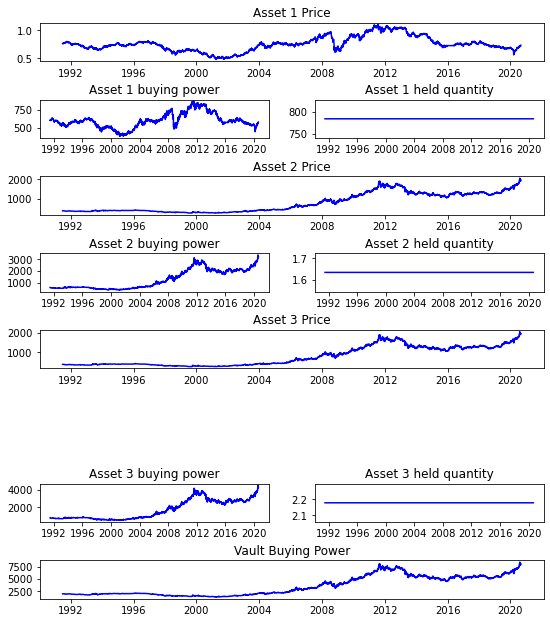

In [21]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model_multiple_assets(
    assets_data,
    [0.3, 0.3, 0.4],
    starting_buying_power=2000,
    slippage=0.01,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

print()
print("Ending with values")
PP.pprint(config)
print()

plot_multiple_assets_results(results)

Start with values {'vault_buying_power': 2000, 'a': 1307.18954248366, 'b': 2.7233115468409586, 'a_buying_power': 1000.0, 'b_buying_power': 1000.0}

Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop s

Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell 

Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell 

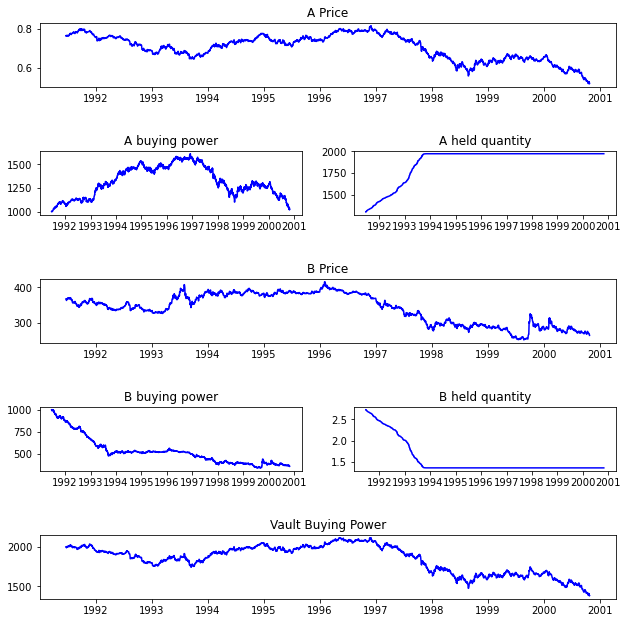

In [22]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

print("Ending with values")
PP.pprint(config)
print()

plot_2_assets_results(results)

## IMP. Modified simulation model, version with * and / signs reversed. 

In [23]:
def simulate_model_multiple_assets_test(assets_data, assets_ratio, starting_buying_power=2000, slippage=0.05,
                                        sell_apr_percentage = 0.01, rebalance_interval_days=7, stop_sell=0.5,
                                        buying_power_stoploss=0.3):
    
    assert(len(assets_data) == len(assets_ratio))
    assert(sum(assets_ratio) == 1)
    
    no_of_assets = len(assets_data)
    
    assets_previous_price = [asset_df.iloc[0, 1] for asset_df in assets_data]
    min_assets_balance_allowed = []
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    plot_data = {
        'no_of_assets': no_of_assets,
        'dates': [],
        'vault': [],
        'vault_buying_power': [],
    }
    
    config = {
        'vault_buying_power': starting_buying_power,
    }
    
    for i in range(no_of_assets):
        plot_data[f'asset_{i+1}'] = []
        plot_data[f'asset_{i+1}_buying_power'] = []
        plot_data[f'asset_{i+1}_price'] = []
        
        config[f'asset_{i+1}'] = (assets_ratio[i] * starting_buying_power) * assets_previous_price[i]
        config[f'asset_{i+1}_buying_power'] = assets_ratio[i] * starting_buying_power
        min_assets_balance_allowed.append((1 - stop_sell) * config[f'asset_{i+1}'])
    
    print('Start with values\n', config)
    print()
    
    for i in assets_data[0].index.to_list():
        date = assets_data[0].loc[i, 'Date']
        assets_price = [asset_df.iloc[i, 1] for asset_df in assets_data]
        
        # Calculate old assets and overall buying power.
        old_assets_buying_power = [config[f'asset_{i+1}_buying_power'] for i in range(no_of_assets)]
        old_buying_power = sum(old_assets_buying_power)
        
        # Calculate new assets buying power.
        new_assets_balance = [config[f'asset_{i+1}'] for i in range(no_of_assets)]
        new_assets_buying_power = [new_assets_balance[i] / assets_price[i] for i in range(no_of_assets)]
        
        for i in range(no_of_assets):
            config[f'asset_{i+1}_buying_power'] = new_assets_buying_power[i]
        
        # Calculate new overall buying power.
        new_buying_power = sum(new_assets_buying_power)
        
        # Now the target buying power should be something that maintains the ratio we 
        # have above.
        target_assets_buying_power = [new_buying_power * assets_ratio[i] for i in range(no_of_assets)]

        # Caclulate the change in buying power.
        diff_assets_buying_power = [
            abs(new_assets_buying_power[i] - old_assets_buying_power[i]) for i in range(no_of_assets)
        ]
        
        # Calculating diff of asset bp with other asset bp. Taking maximum for each asset with other asset.(Current code.)
        # SEE Same step for 2 asset model.
        # Questions YA:
        # Q1: We could take the max of all the difference bp matrix and rebalance all accordingly.
        # Q2: Could take max of diff of a asset with all other asset and rebalance only a.(Current code.)
        # 
        # Q3: Could take max of diff of a asset and rebalance the asset with max (a - asset) also along with a.(
        #     Point a: Will need to check if 'asset' was the one that was used to rebalance asset 'a'.
        #     Point b: Situation where 'asset' has max diff with some other asset but was used to rebalance asset 'a'
        # )
        assets_buying_power_to_rebalance = []
        for i in range(no_of_assets):
            diff_assets_buying_power_temp = []
            
            for j in range(no_of_assets):
                diff_assets_buying_power_temp.append(abs(diff_assets_buying_power[i] - diff_assets_buying_power[j]))
            
            assets_buying_power_to_rebalance.append(max(diff_assets_buying_power_temp))
        
        for i in range(no_of_assets):
            if (new_assets_buying_power[i] < target_assets_buying_power[i]):
                new_assets_balance[i] -= assets_buying_power_to_rebalance[i] * (assets_price[i] * slippage_multiplier)
            else:
                new_assets_balance[i] += assets_buying_power_to_rebalance[i] * (assets_price[i] * slippage_multiplier)
        
        # IMP YA: As we can see here a and b are balanced accordingly to diff(new-old)(a) & diff(new-old)(b)
        # Hence the above questions   
        # if (new_a_buying_power < target_a_buying_power):
            # if A has more buying power then we sell `sell_apr_percentage`% of the profits in A and buy B
            # new_a_balance -= buying_power_to_rebalance / (a * slippage_multiplier)
            # new_b_balance += buying_power_to_rebalance / (b * slippage_multiplier)
        # elif (new_b_buying_power < target_b_buying_power):
            # and vice versa
            # new_a_balance += buying_power_to_rebalance / (a * slippage_multiplier)
            # new_b_balance -= buying_power_to_rebalance / (b * slippage_multiplier)
        
        stopsell_hit = False
        # check if we are hitting our stop sell or not...
        for i in range(no_of_assets):
            if new_assets_balance[i] <= min_assets_balance_allowed[i]:
                stopsell_hit = True
                break
            
        # check if we are trading in the right day or not
        invalid_trading_day = i % rebalance_interval_days != 0
        
        # check if there is no change in the buying power
        no_change_in_buying_power = new_buying_power < old_buying_power
        
        # check if we are selling too much of a particular asset. Ideally we should make 
        # sure that we buy/sell as much so that the
        # underlying does not get fully sold off.
        selling_too_much = False
        for i in range(no_of_assets):
            if new_assets_balance[i] <= 0:
                selling_too_much = True
                break
        
        # don't do anything if any of the following conditions are being hit
        if (invalid_trading_day or stopsell_hit or no_change_in_buying_power or selling_too_much):
            plot_data['dates'].append(date)
            plot_data['vault_buying_power'].append(new_buying_power)
            
            for i in range(no_of_assets):
                plot_data[f'asset_{i+1}'].append(config[f'asset_{i+1}'])
                plot_data[f'asset_{i+1}_price'].append(assets_price[i])
                plot_data[f'asset_{i+1}_buying_power'].append(new_assets_buying_power[i])
            
            if (stopsell_hit and not no_change_in_buying_power and not invalid_trading_day):
                pass
                # print('Vault triggered a trade but was cancelled because the stop sell was hit')
                
            if (selling_too_much and not no_change_in_buying_power and not invalid_trading_day):
                pass
                # print('Vault triggered a trade but was cancelled because we\'d have fully sold one asset')
                
            continue
            
        # Check if our stop loss has been hit or not. in which case, we bail..
        if (new_buying_power - starting_buying_power) / starting_buying_power <= buying_power_stoploss * -1: 
            print('Breaking')
            break
    
        # Recalculate the new vault's buying power
        counter += 1
        for i in range(no_of_assets):
            config[f'asset_{i+1}'] = new_assets_balance[i]
            config[f'asset_{i+1}_buying_power'] = new_assets_balance[i] / assets_price[i]
            config['vault_buying_power'] = new_buying_power
        
        plot_data['dates'].append(date)
        
        buying_power_accumulator = 0
        for i in range(no_of_assets):
            plot_data[f'asset_{i+1}'].append(config[f'asset_{i+1}'])
            plot_data[f'asset_{i+1}_price'].append(assets_price[i])
            plot_data[f'asset_{i+1}_buying_power'].append(config[f'asset_{i+1}_buying_power'])
            buying_power_accumulator += config[f'asset_{i+1}_buying_power']
    
        plot_date['vault_buying_power'] = buying_power_accumulator

    print()
    print("Finished with %d rebalances" % counter)
    print("Final buying power of the vault is %d" % (new_buying_power))
        
    return plot_data, config

In [24]:
def simulate_model_test(
    data, 
    ratio_a=0.5, ratio_b=0.5, 
    starting_buying_power=2000, 
    slippage=0.05,
    sell_apr_percentage = 0.01, 
    rebalance_interval_days=7, 
    stop_sell=0.5,
    buying_power_stoploss=0.3
):
    a_prev = data.iloc[0, 1]
    b_prev = data.iloc[0, 2]
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    plot_data = {
        'dates': [],
        'vault': [],
        'vault_buying_power': [],
        'a': [],
        'b': [],
        'a_price': [],
        'b_price': [],
        'a_buying_power': [],
        'b_buying_power': []
    }
    
    START_CONFIG = {
        'vault_buying_power': starting_buying_power,
        'a': (ratio_a * starting_buying_power) * a_prev,
        'b': (ratio_b * starting_buying_power) * b_prev,
        'a_buying_power': ratio_a * starting_buying_power,
        'b_buying_power': ratio_b * starting_buying_power
    }
    
    min_balance_allowed_a = (1 - stop_sell) * START_CONFIG['a']
    min_balance_allowed_b = (1 - stop_sell) * START_CONFIG['b']
    
    print('Start with values', START_CONFIG)
    print()
    
    for i in data.index.to_list():
        a = data.iloc[i, 1]
        b = data.iloc[i, 2]

        # calculate old buying power
        old_a_buying_power = START_CONFIG['a_buying_power']
        old_b_buying_power = START_CONFIG['b_buying_power']
        old_buying_power = old_a_buying_power + old_b_buying_power
        
        # calculate new buying power
        new_a_balance = START_CONFIG['a']
        new_b_balance = START_CONFIG['b']
        new_a_buying_power = new_a_balance / a
        new_b_buying_power = new_b_balance / b
        
        START_CONFIG['a_buying_power'] = new_a_buying_power
        START_CONFIG['b_buying_power'] = new_b_buying_power
        
        # check if the new buygin power has increased; only in which case do we rebalance
        new_buying_power = new_a_buying_power + new_b_buying_power
        
        # now the target buying power should be something that maintains the ratio we 
        # have above.
        target_a_buying_power = new_buying_power * ratio_a
        target_b_buying_power = new_buying_power * ratio_b


        # caclulate the change in buying power and how much of the buying power we wish to rebalance
        diff_a_buying_power = abs(new_a_buying_power - old_a_buying_power)
        diff_b_buying_power = abs(new_b_buying_power - old_b_buying_power)
        diff_a_b_buying_power = abs(diff_a_buying_power - diff_b_buying_power)
        buying_power_to_rebalance = diff_a_b_buying_power * sell_apr_percentage
        
        # Rebalance the assets.       
        if (new_a_buying_power < target_a_buying_power):
            # if A has more buying power then we sell `sell_apr_percentage`% of the profits in A and buy B
            new_a_balance -= buying_power_to_rebalance * (a * slippage_multiplier)
            new_b_balance += buying_power_to_rebalance * (b * slippage_multiplier)
        elif (new_b_buying_power < target_b_buying_power):
            # and vice versa
            new_a_balance += buying_power_to_rebalance * (a * slippage_multiplier)
            new_b_balance -= buying_power_to_rebalance * (b * slippage_multiplier)
        
        # check if we are hitting our stop sell or not...
        stopsell_hit = new_a_balance <= min_balance_allowed_a or new_b_balance <= min_balance_allowed_b
        
        # check if we are trading in the right day or not
        invalid_trading_day = i % rebalance_interval_days != 0
        
        # check if there is no change in the buying power
        no_change_in_buying_power = new_buying_power < old_buying_power
        
        # check if we are selling too much of a particular asset. Ideally we should make 
        # sure that we buy/sell as much so that the
        # underlying does not get fully sold off.
        selling_too_much = new_a_balance <= 0 or new_b_balance <= 0
        
        # don't do anything if any of the following conditions are being hit
        if (invalid_trading_day or stopsell_hit or no_change_in_buying_power or selling_too_much):
            plot_data['dates'].append(df.loc[i, 'Date'])
            plot_data['vault_buying_power'].append(new_buying_power)
            plot_data['a'].append(START_CONFIG['a'])
            plot_data['b'].append(START_CONFIG['b'])
            plot_data['a_price'].append(a)
            plot_data['b_price'].append(b)
            plot_data['a_buying_power'].append(new_a_buying_power)
            plot_data['b_buying_power'].append(new_b_buying_power)
            
            if (stopsell_hit and not no_change_in_buying_power and not invalid_trading_day):
                pass
                # print('Vault triggered a trade but was cancelled because the stop sell was hit')
                
            if (selling_too_much and not no_change_in_buying_power and not invalid_trading_day):
                pass
                # print('Vault triggered a trade but was cancelled because we\'d have fully sold one asset')
                
            continue
            
        # Check if our stop loss has been hit or not. in which case, we bail..
        if (new_buying_power - starting_buying_power) / starting_buying_power <= buying_power_stoploss * -1: 
            print('Breaking')
            break
    
        # Recalculate the new vault's buying power
        counter += 1
        START_CONFIG['a'] = new_a_balance
        START_CONFIG['b'] = new_b_balance
        START_CONFIG['vault_buying_power'] = new_buying_power
        START_CONFIG['a_buying_power'] = new_a_balance / a
        START_CONFIG['b_buying_power'] = new_b_balance / b
        
        plot_data['dates'].append(df.loc[i, 'Date'])
        plot_data['vault_buying_power'].append(START_CONFIG['a_buying_power'] + START_CONFIG['b_buying_power'])
        plot_data['a'].append(START_CONFIG['a'])
        plot_data['b'].append(START_CONFIG['b'])
        plot_data['a_price'].append(a)
        plot_data['b_price'].append(b)
        plot_data['a_buying_power'].append(START_CONFIG['a_buying_power'])
        plot_data['b_buying_power'].append(START_CONFIG['b_buying_power'])

        a_prev, b_prev = a, b
        
    print("finished with %d rebalances" % counter)
    print("final buying power of the vault is %d" % (new_buying_power))
        
    return plot_data, START_CONFIG

Start with values
 {'vault_buying_power': 2000, 'asset_1': 459.0, 'asset_1_buying_power': 600.0, 'asset_2': 220320.0, 'asset_2_buying_power': 600.0, 'asset_3': 293760.0, 'asset_3_buying_power': 800.0}


Finished with 0 rebalances
Final buying power of the vault is 885

Ending with values
{'asset_1': 459.0,
 'asset_1_buying_power': 623.8956096234879,
 'asset_2': 220320.0,
 'asset_2_buying_power': 112.1929360003259,
 'asset_3': 293760.0,
 'asset_3_buying_power': 149.5905813337679,
 'vault_buying_power': 2000}



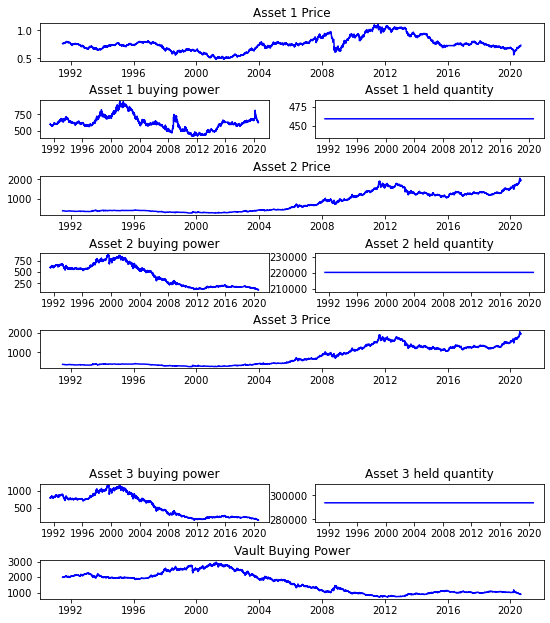

In [25]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model_multiple_assets_test(
    assets_data,
    [0.3, 0.3, 0.4],
    starting_buying_power=2000,
    slippage=0.01,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

print()
print("Ending with values")
PP.pprint(config)
print()

plot_multiple_assets_results(results)

Start with values {'vault_buying_power': 2000, 'a': 765.0, 'b': 367200.0, 'a_buying_power': 1000.0, 'b_buying_power': 1000.0}

Breaking
finished with 1242 rebalances
final buying power of the vault is 1386
Ending with values
{'a': 382.50000730722405,
 'a_buying_power': 514.8048550568292,
 'b': 551734.6519489774,
 'b_buying_power': 871.3434174810128,
 'vault_buying_power': 1448.178799917356}



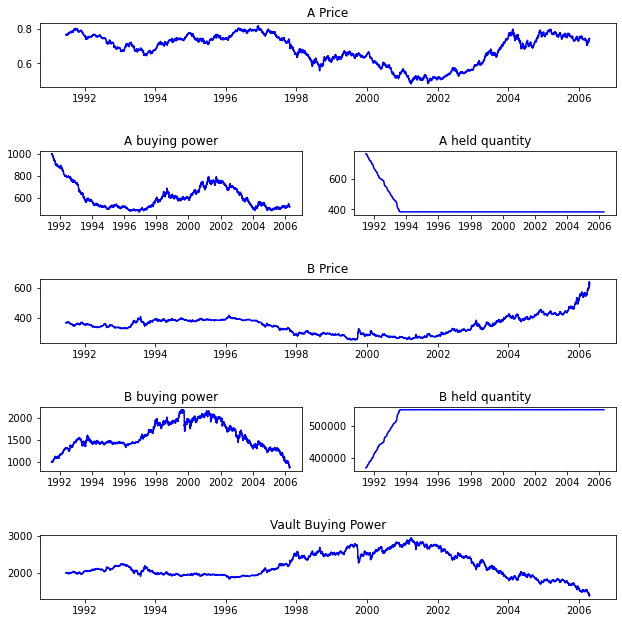

In [26]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model_test(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

print("Ending with values")
PP.pprint(config)
print()

plot_2_assets_results(results)

### More conditions: 
Status: TODO

In [ ]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model(
    df,
    ratio_a=0.5,
    ratio_b=0.5, 
    starting_buying_power=2000,
    slippage=0.01,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

In [ ]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

In [ ]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

# eventually we run out of one side of asset because we sell too much; 
# so we should ideally avoid this scenario..

In [ ]:
# USD and GOLD with a 50-50 ratio with no rebalancing
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    sell_apr_percentage=0
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

In [ ]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model_test(
    df,
    ratio_a=0.5,
    ratio_b=0.5, 
    starting_buying_power=2000,
    slippage=0.01,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.3
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

### Artificial Data Simulations:
Status: TODO

In [ ]:
# With one appreciating asset and one depreciating asset. The net result is on the positive.
results, config = simulate_model(
    appreciating_asset,
    depreciating_asset,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)

In [ ]:
# With two depreciating assets. Really nothing we can do here. the
# net loss in the vault is the averaged loss; Which shows the importance of
# choosing two assets that are hedges of each other...

results, config = simulate_model(
    depreciating_asset,
    depreciating_asset,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)